# WikiRecs
A project to recommend the next Wikipedia article you might like to edit

In [225]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import wikipedia
import requests
import os
import wikirecs as wr
import implicit
from scipy.sparse import csr_matrix, csc_matrix, lil_matrix
from tqdm.auto import tqdm
import umap
import pickle
import collections
import recommenders

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)

In [3]:
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [4]:
cols = ['userid', 'user', 'pageid', 'title',
       'timestamp', 'sizediff']


In [23]:
df = wr.get_sample_of_users(10000)

# Get recent changes (to get a list of users)

In [37]:
# wr.get_sample_of_users(edit_lookback=100000, outfile="sampled_users.pickle")

Earliest timestamp: 2021-02-11T05:35:34Z
Latest timestamp: 2021-02-11T05:38:35Z
Number of distinct users: 72
Number of distinct users: 72
Mean number of edits per user in timeframe: 1.39
Number of distinct pages edited: 89
Mean number of edits per page in timeframe: 1.12


,user,userid
0,Another Believer,5886041
1,Gardenkur,40527536
2,William Avery,1398
3,Nexus000,20212957
4,Drones100,41173297
5,053pvr,41042556
6,JCwiki21,14633420
7,CommonSentiments,27015145
8,MarnetteD,220924
9,Gummycow,40751078


In [ ]:
wr.print_user_history(all_histories, user="Yoninah")

In [ ]:
all_histories.loc[:,'userid'] = all_histories.loc[:,'userid'].astype(int)

In [ ]:
all_histories['title'] = all_histories['title'].astype(str)

In [ ]:
sampled_users

In [ ]:
wr.save_pickle(all_histories,"all_histories.pickle")

# Load all_histories (raw data), transform and split 

In [175]:
%%time
all_histories = wr.load_pickle('all_histories.pickle')

print("Length raw edit history data: {}".format(len(all_histories)))

## Add one particular user

with open("username.txt", "r") as file:
    username = next(file)

oneuser = wr.get_edit_history(user=username,
                    latest_timestamp="2020-12-30T02:02:09Z",
                    earliest_timestamp="2019-12-30T02:02:09Z")
oneuser = pd.DataFrame(oneuser).loc[:,cols]
all_histories = pd.concat([all_histories, oneuser], ignore_index=True)

print("Length after adding one user: {}".format(len(all_histories)))

Length raw edit history data: 14998090
Length after adding one user: 14998470
CPU times: user 13.3 s, sys: 16 s, total: 29.3 s
Wall time: 42.8 s


## Build lookup tables

In [176]:
# Page id to title and back
lookup = all_histories.drop_duplicates(subset=['pageid']).loc[:,['pageid','title']]
p2t = dict(zip(lookup.pageid, lookup.title))
t2p = dict(zip(lookup.title, lookup.pageid))

# User id to name and back
lookup = all_histories.drop_duplicates(subset=['userid']).loc[:,['userid','user']]
u2n = dict(zip(lookup.userid, lookup.user))
n2u = dict(zip(lookup.user, lookup.userid))


In [177]:
# Page id and userid to index in cooccurence matrix and back
pageids = np.sort(all_histories.pageid.unique())
userids = np.sort(all_histories.userid.unique())
 
p2i = {pageid:i for i, pageid in enumerate(pageids)}
u2i = {userid:i for i, userid in enumerate(userids)}


i2p = {v: k for k, v in p2i.items()}
i2u = {v: k for k, v in u2i.items()}


In [178]:
# User name and page title to index and back
n2i = {k:u2i[v] for k, v in n2u.items() if v in u2i}
t2i = {k:p2i[v] for k, v in t2p.items() if v in p2i}

i2n = {v: k for k, v in n2i.items()}
i2t = {v: k for k, v in t2i.items()}

In [179]:
wr.save_pickle((p2t, t2p, u2n, n2u, p2i, u2i, i2p, i2u, n2i, t2i, i2n, i2t), 'lookup_tables.pickle')

In [52]:
p2t, t2p, u2n, n2u, p2i, u2i, i2p, i2u, n2i, t2i, i2n, i2t = wr.load_pickle('lookup_tables.pickle')

## EDA on raw histories

In [46]:
# Look at the distribution of edit counts
edit_counts = all_histories.groupby('userid').userid.count().values

Median edit counts: 135
Number over threshold 5: 9558 (83%)


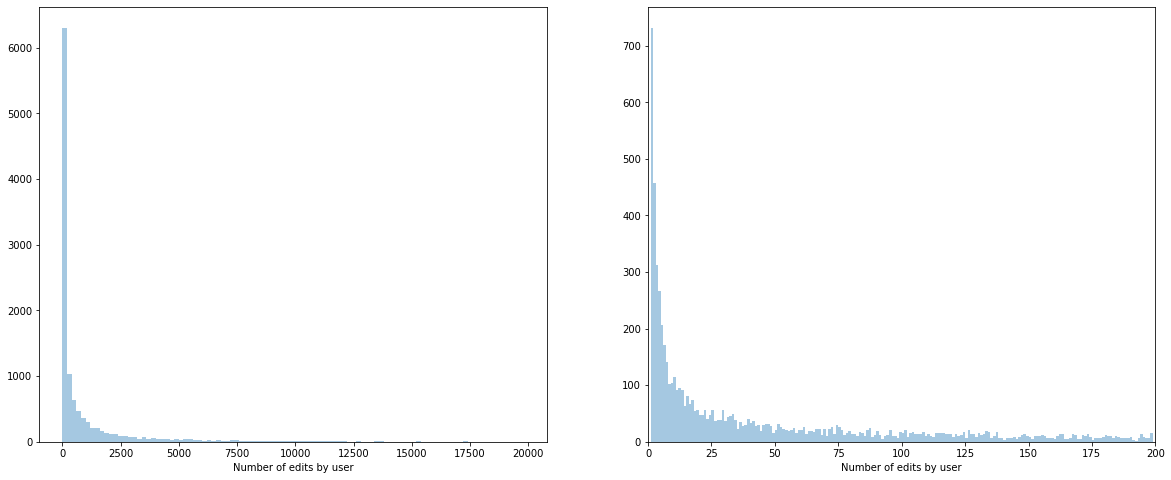

In [48]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(edit_counts,kde=False,bins=np.arange(0,20000,200))
plt.xlabel('Number of edits by user')
plt.subplot(1,2,2)
sns.distplot(edit_counts,kde=False,bins=np.arange(0,200,1))
plt.xlim([0,200])
plt.xlabel('Number of edits by user')
num_counts = len(edit_counts)
print("Median edit counts: %d" % np.median(edit_counts))
thres = 5
over_thres = np.sum(edit_counts > thres)
print("Number over threshold %d: %d (%.f%%)" % (thres, over_thres, 100*over_thres/num_counts))

In [49]:
# Most edits by user
all_histories.groupby(['userid','user']).userid.count().sort_values(ascending=False)

userid    user                          
1276024   Lugnuts                           100000
28779459  Lepricavark                        99989
7611264   AnomieBOT                          99960
1261736   Red Director                       99673
7852030   Materialscientist                  99637
196446    BD2412                             98184
937705    Iridescent                         94032
1544984   Dawnseeker2000                     92428
1189543   Simeon                             91939
753665    Ser Amantio di Nicolao             82123
525927    Chris the speller                  75883
5718152   Arjayay                            67039
917223    Dl2000                             63156
96340     Markussep                          61272
22041646  Narky Blert                        60731
26021349  MB                                 58959
2278355   Keith D                            57307
7098284   Tassedethe                         52503
11308236  John of Reading                

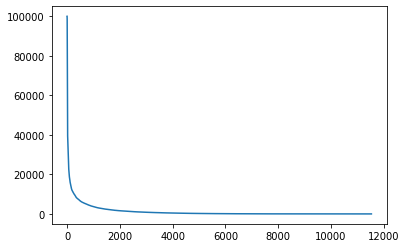

In [50]:
# Find the elbow in number of edits
plt.plot(all_histories.groupby(['userid','user']).userid.count().sort_values(ascending=False).values)
# plt.ylim([0,20000])

In [51]:
# What are the most popular pages (edited by the most users)
page_popularity = all_histories.drop_duplicates(subset=['title','user']).groupby('title').count().user.sort_values()

pd.set_option('display.max_rows', 1000)
page_popularity.iloc[-1000:].iloc[::-1]

title
COVID-19 pandemic                                                                          686
COVID-19 pandemic in the United States                                                     376
Deaths in 2020                                                                             375
2020 United States presidential election                                                   340
George Floyd protests                                                                      328
Coronavirus disease 2019                                                                   299
Killing of George Floyd                                                                    275
Kamala Harris                                                                              249
Joe Biden                                                                                  243
Donald Trump                                                                               233
Misinformation related to the COVID-19 pande

## Clean data

### Remove top N most popular pages

In [91]:
TOPN = 20
popularpages = all_histories.drop_duplicates(subset=['title','pageid','userid']).groupby(['title','pageid']).count().user.sort_values()[-TOPN:]

before_count = len(all_histories)

In [92]:
popularpages

title                                            pageid  
Amy Coney Barrett                                53992581    165
Ukraine International Airlines Flight 752        62776032    166
2020 Nagorno-Karabakh war                        65431221    167
Severe acute respiratory syndrome coronavirus 2  62786585    168
2020                                             51396       185
List of deaths due to COVID-19                   63417935    193
2020 Beirut explosion                            64752725    204
COVID-19 pandemic by country and territory       62938755    211
COVID-19 pandemic in the United Kingdom          63216936    212
Misinformation related to the COVID-19 pandemic  63055098    216
Donald Trump                                     4848272     233
Joe Biden                                        145422      243
Kamala Harris                                    3120522     249
Killing of George Floyd                          64076090    275
Coronavirus disease 2019        

In [93]:
popular_pageids = popularpages.index.get_level_values(level='pageid').values
is_popular_page_edit = all_histories.pageid.isin(popular_pageids)
all_histories = all_histories.loc[~is_popular_page_edit]
after_count = len(all_histories)
print("%d edits (%.1f%%) were in top %d popular pages. Length after removing: %d" % (np.sum(is_popular_page_edit), 
                                                                                     100* np.sum(is_popular_page_edit)/before_count,
                                                                                     TOPN,
                                                                                     after_count)
     )

70227 edits (0.5%) were in top 20 popular pages. Length after removing: 14928243


In [94]:
print("Number of unique page ids: {}".format(len(all_histories.pageid.unique())))

Number of unique page ids: 3428315


### Remove users with too many or too few edits

In [95]:
MIN_EDITS = 5
MAX_EDITS = 10000

In [96]:
all_user_edit_counts = all_histories.groupby(['userid','user']).userid.count()

In [97]:
# Remove users with too few edits
keep_user = all_user_edit_counts.values >= MIN_EDITS

# Remove users with too many edits
keep_user = keep_user & (all_user_edit_counts.values <= MAX_EDITS)

# Remove users with "bot" in the name
is_bot = ['bot' in username.lower() for username in all_user_edit_counts.index.get_level_values(1).values]
keep_user = keep_user & ~np.array(is_bot)
print("Keep %d users out of %d (%.1f%%)" % (np.sum(keep_user), len(all_user_edit_counts), 100*float(np.sum(keep_user))/len(all_user_edit_counts)))

Keep 9485 users out of 11533 (82.2%)


In [98]:
userids_to_keep = all_user_edit_counts.index.get_level_values(0).values[keep_user]

In [99]:
all_histories = all_histories.loc[all_histories.userid.isin(userids_to_keep)]

In [100]:
all_histories = all_histories.reset_index(drop=True)

In [101]:
print("Length after removing users: {}".format(len(all_histories)))

Length after removing users: 9159904



## Build test and training set

In [102]:
# all_histories = all_histories.drop_duplicates()
# all_histories = all_histories.reset_index(drop=True)


In [103]:
# Make a test set from the most recent edit by each user
histories_test = all_histories.groupby(['userid','user'],as_index=False).first()

In [104]:
histories_train = wr.dataframe_set_subtract(all_histories, histories_test)

In [105]:
print("Length of test set: {}".format(len(histories_test)))
print("Length of training after removal of test: {}".format(len(histories_train)))


Length of test set: 9485
Length of training after removal of test: 9150419


In [106]:
print("Number of pages in training set: {}".format(len(histories_train.pageid.unique())))
print("Number of users in training set: {}".format(len(histories_train.userid.unique())))
print("Number of pages with > 1 user editing: {}".format(np.sum(histories_train.drop_duplicates(subset=['title','user']).groupby('title').count().user > 1)))

Number of pages in training set: 2024883
Number of users in training set: 9485
Number of pages with > 1 user editing: 652251


In [107]:
wr.save_pickle(histories_train, 'histories_train.pickle')
wr.save_pickle(histories_test, 'histories_test.pickle')

# Build matrix for implicit collaborative filtering

In [169]:
%%time

# Get the user/page edit counts
for_implicit = histories_train.groupby(["userid","pageid"]).count().timestamp.reset_index().rename(columns={'timestamp':'edits'})
for_implicit.loc[:,'edits'] = for_implicit.edits.astype(np.int32)

CPU times: user 5.01 s, sys: 1.87 s, total: 6.88 s
Wall time: 7.19 s


In [109]:
wr.save_pickle(for_implicit, 'for_implicit.pickle')

## Test pivot that only works on a smaller set

In [174]:
# for_implicit = wr.load_pickle('for_implicit.pickle')
# for_implicit = for_implicit.pivot(index='pageid',columns='userid',values='edits').fillna(0).astype(int)

# pageid_to_index = {pageid:i for i, pageid in enumerate(pageids)}


# for_implicit = csc_matrix(for_implicit.values)

# model = implicit.als.AlternatingLeastSquares(factors=50)


# model.fit(for_implicit)


# p = pageid_to_index[561315]

# page_lookup.loc[pageids[p]]

# results = model.similar_items(p,20)

# page_lookup.loc[[pageids[r[0]] for r in results]]

## Build large co-occurrence matrix incrementally

In [54]:
for_implicit = wr.load_pickle('for_implicit.pickle')

In [180]:
# Make empty sparse matrix
implicit_matrix = lil_matrix((len(pageids), len(userids)), dtype=np.int32)
implicit_matrix.shape

(3428335, 11533)

In [181]:
%%time
for i, row  in tqdm(for_implicit.iterrows(), total=len(for_implicit)):
    implicit_matrix[p2i[row.pageid], u2i[row.userid]] = row.edits

  0%|          | 0/3614867 [00:00<?, ?it/s]

CPU times: user 8min 20s, sys: 7.6 s, total: 8min 27s
Wall time: 8min 37s


In [182]:
implicit_matrix = csc_matrix(implicit_matrix)

In [183]:
wr.save_pickle(implicit_matrix,'implicit_matrix.pickle')

### Test the matrix and indices

In [184]:
# implicit_matrix = wr.load_pickle('implicit_matrix.pickle')

In [210]:
indices = np.flatnonzero(implicit_matrix[:,n2i[username]].toarray())

In [184]:
t2p['The Simpsons']

29838

In [311]:
# Item to item recs by looking for items edited by the same editors (count how many editors overlap)

veditors = np.flatnonzero(implicit_matrix[t2i['The Sound of Music'],:].toarray())

indices =  np.flatnonzero(np.sum(implicit_matrix[:,veditors] > 0,axis=1))

totals = np.asarray(np.sum(implicit_matrix[:,veditors] > 0 ,axis=1)[indices])

sorted_order = np.argsort(totals.squeeze())

[i2t.get(i, "")  + " " + str(total[0]) for i,total in zip(indices[sorted_order],totals[sorted_order])][::-1]

['The Sound of Music 4',
 'Edward German 2',
 'Guilty Men 2',
 'Chu Chin Chow 2',
 'Cinderella (1997 film) 2',
 'Winston Churchill 2',
 'J. Arthur Rank 2',
 'Henry Labouchère 2',
 'Cats (musical) 2',
 'Caissie Levy 2',
 'Noël Coward 2',
 'Hay Fever (play) 2',
 'Aldwych farce 2',
 'Fallen Angels (play) 2',
 'Noël Coward on stage and screen 2',
 'Marion Terry 2',
 'Look After Lulu! 2',
 'Shadow Play (play) 2',
 'Hands Across the Sea (play) 2',
 'The Astonished Heart 2',
 'Violet Vanbrugh 2',
 'John Masefield 2',
 'Jodi Benson 2',
 'Cicely Courtneidge 2',
 'Ivor Novello 2',
 'Sleeping Beauty (1959 film) 2',
 'Kelly Reilly 2',
 'Robert Courtneidge 2',
 'After the Ball (musical) 2',
 'Letty Lind 2',
 'Anatole de Grunwald 2',
 'Arthur Bourchier 2',
 'Cultural impact of Noël Coward 2',
 'Pat Carroll 2',
 'Patti LuPone 2',
 'Shirley & Company 1',
 'Teenage Mutant Ninja Turtles II: The Secret of the Ooze 1',
 'John Normington 1',
 'Dundee (UK Parliament constituency) 1',
 'Nuremberg Diary 1',
 

In [ ]:
# Histories of editors who had that item
for ved in veditors:
    print("\n\n\n" + i2n[ved])
    wr.print_user_history(all_histories, user=i2n[ved])

In [195]:
from sklearn.feature_extraction.text import TfidfTransformer
implicit_tfidf = TfidfTransformer().fit_transform(implicit_matrix)

In [196]:
veditors = np.flatnonzero(implicit_tfidf[t2i['Bill Cosby'],:].toarray())

indices =  np.flatnonzero(np.sum(implicit_tfidf[:,veditors] > 0,axis=1))

totals = np.asarray(np.sum(implicit_tfidf[:,veditors],axis=1)[indices])

sorted_order = np.argsort(totals.squeeze())
[i2t[i]  + " " + str(total[0]) for i,total in zip(indices[sorted_order],totals[sorted_order])][::-1]

['Bill Cosby 4.048653546781649',
 'Todd Rundgren 1.4603982717482105',
 'Thong Song 1.4138992829840151',
 'Bytham Castle 1.413884538326843',
 'Rouelbeau Castle 1.413884538326843',
 '2019–20 Veszprém KC season 1.413884538326843',
 '2000–01 A Group 1.413884538326843',
 'Wedding of Princess Margaret and Antony Armstrong-Jones 1.413884538326843',
 'First Djerad government 1.413884538326843',
 'Iran University of Medical Sciences 1.413884538326843',
 'Diana Laura Riojas 1.413884538326843',
 'Neale Fong 1.413884538326843',
 'Meer Abru 1.413884538326843',
 'List of Lechia Gdańsk records and statistics 1.413884538326843',
 'Alessandro Quaini 1.413884538326843',
 'List of The Mr. Peabody & Sherman Show episodes 1.4125899584663384',
 'Victim of the New Disease 1.410814078653265',
 'Tiruppattur, Sivaganga 1.409184904756339',
 'Franckensteina Strataemontanus 1.40283433209433',
 'List of awards and nominations received by Whoopi Goldberg 1.3989313663757024',
 'Kalie Shorr 1.3906550513459224',
 'The 

# Fit implicit model

In [194]:
wr.load_pickle('implicit_matrix.pickle')

<2024883x9485 sparse matrix of type '<class 'numpy.int32'>'
	with 0 stored elements in Compressed Sparse Column format>

In [296]:
num_factors = 150

In [297]:
model = implicit.als.AlternatingLeastSquares(factors=num_factors)

In [274]:
# implicit_matrix[implicit_matrix > 1] = 1

In [298]:
%%time
model.fit(implicit_matrix)


  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 20min 32s, sys: 6min 34s, total: 27min 6s
Wall time: 17min 14s


In [299]:
wr.save_pickle(model,'als%d_model.pickle' % num_factors)

# Evaluate model

## Item to item recommendation

In [286]:
results = model.similar_items(t2i['George Clooney'],20)

In [308]:
results = model.similar_items(t2i['The Music Man'],20)

In [309]:
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['The Music Man 1.0000',
 'Anything Goes 0.9893',
 'Carousel (musical) 0.9885',
 'The Rothschilds (musical) 0.9883',
 'My Diarrhe (book) 0.9880',
 'Cinderella (2013 Broadway production) 0.9875',
 'Annie Get Your Gun (musical) 0.9875',
 'Peter Bartlett (actor) 0.9873',
 'List of pedestrian circumnavigators 0.9871',
 'Alice in Wonderland (musical) 0.9871',
 'Francis Jue 0.9869',
 'Dorothy Hepworth 0.9869',
 'Jerome Kern 0.9869',
 'Gale Storm 0.9868',
 'Some Enchanted Evening 0.9868',
 'List of songs composed by Jerome Kern 0.9868',
 'Just the Beginning (Grace VanderWaal album) 0.9868',
 'Martin Jetpack 0.9868',
 'William Finn 0.9868',
 "Major-General's Song 0.9867"]

In [301]:
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['George Clooney 1.0000',
 'Zoey Deutch 0.8706',
 'Ralph Ineson 0.8573',
 'Adepero Oduye 0.8446',
 'Lackawanna Blues (film) 0.8438',
 'Taraji P. Henson 0.8423',
 'Patricia Arquette 0.8417',
 'Lynn Whitfield 0.8399',
 'Lackawanna Blues 0.8384',
 'Imogen Poots 0.8367',
 'Zoë Kravitz 0.8352',
 'Yahya Abdul-Mateen II 0.8309',
 'Bobby Cannavale 0.8309',
 'Vincent Kartheiser 0.8291',
 'Steve Zahn 0.8286',
 'Jamie Bell 0.8281',
 'Octavia Spencer 0.8276',
 'Olivia Colman 0.8260',
 'Blair Underwood 0.8250',
 'Florian Zeller 0.8250']

In [287]:
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['George Clooney 1.0000',
 'Laura Dern 0.9047',
 'Zoey Deutch 0.9001',
 'Octavia Spencer 0.8897',
 'Carmen Ejogo 0.8887',
 'Lackawanna Blues (film) 0.8874',
 'Alex Borstein 0.8872',
 'Adepero Oduye 0.8867',
 'Olivia Colman 0.8860',
 'Greta Gerwig 0.8857',
 'Elisabeth Moss 0.8849',
 'Hippolyte Girardot 0.8846',
 'Justin Bartha 0.8844',
 'Patricia Arquette 0.8826',
 'Lackawanna Blues 0.8826',
 'Taraji P. Henson 0.8806',
 'Chloë Grace Moretz 0.8796',
 'Tina Fey 0.8776',
 'Lin Shaye 0.8765',
 'Carla Gugino 0.8759']

In [272]:
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['Steven Universe 1.0000',
 'List of Adventure Time episodes 0.9622',
 'List of Our Cartoon President episodes 0.9591',
 'Talking with Chris Hardwick 0.9580',
 'List of Wacky Races (2017 TV series) episodes 0.9580',
 'Infinity Train 0.9545',
 'Skylanders Academy 0.9543',
 'List of Steven Universe episodes 0.9506',
 'Buddy Thunderstruck 0.9460',
 'List of We Bare Bears episodes 0.9454',
 "Rapunzel's Tangled Adventure 0.9451",
 'Dallas Cowboys Cheerleaders: Making the Team 0.9422',
 'List of Ben 10: Ultimate Alien episodes 0.9422',
 'List of Dragon Ball episodes 0.9421',
 'The VeggieTales Show 0.9404',
 "Jupiter's Legacy (TV series) 0.9397",
 'XIII (2003 video game) 0.9391',
 'List of Bakugan: Battle Planet episodes 0.9383',
 'Ballmastrz: 9009 0.9378',
 'List of The Tom and Jerry Show (2014 TV series) episodes 0.9375']

In [213]:
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['The Simpsons 1.0000',
 "Garfield's Babes and Bullets 0.9984",
 'Solarbabies 0.9984',
 "Caillou's Holiday Movie 0.9983",
 'Clang Invasion 0.9983',
 'MoonScoop Group 0.9983',
 'Intimate Relations (1996 film) 0.9982',
 'Sabrina Goes to Rome 0.9981',
 'Blame Canada 0.9981',
 'An Evening with Beverly Luff Linn 0.9980',
 'Spot (franchise) 0.9980',
 'My Spy Family 0.9979',
 'Garfield merchandise 0.9979',
 'The Large Family 0.9978',
 'Sherlock Holmes in the 22nd Century 0.9978',
 'My Knight and Me 0.9978',
 'America Sings 0.9978',
 "Justin's House 0.9978",
 'List of Horrid Henry episodes 0.9978',
 'South Parade Pier 0.9977']

In [220]:
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['Vincent Price 1.0000',
 'Gingerbread 0.9932',
 'Mosaic (web browser) 0.9932',
 'Gabriel Fortuné 0.9910',
 'E. J. Korvette 0.9905',
 'Richard Benjamin Harrison 0.9893',
 'CONELRAD 0.9893',
 'Bistre 0.9884',
 'Characterization 0.9882',
 'Westminster, Maryland 0.9882']

## User to item recommendations

In [322]:
u = n2i["Da Vynci"]

In [323]:
wr.print_user_history(all_histories, userid=u)

In [324]:
recommendations = model.recommend(u, implicit_matrix, N=100, filter_already_liked_items=False)
['%s %.4f' % (i2t[ind], score) for ind, score in recommendations]

['COVID-19 pandemic in Hong Kong 0.0147',
 'COVID-19 vaccine 0.0144',
 '2019–20 Hong Kong protests 0.0118',
 'Hong Kong national security law 0.0113',
 'Remdesivir 0.0112',
 'Boris Johnson 0.0108',
 'COVID-19 pandemic in mainland China 0.0107',
 '2020 Calabasas helicopter crash 0.0104',
 '999-year leases in Hong Kong 0.0098',
 'Statue of Edward Colston 0.0093',
 'Cyberpunk 2077 0.0091',
 'Timeline of the COVID-19 pandemic in January 2020 0.0090',
 'Kobe Bryant 0.0089',
 'Chadwick Boseman 0.0088',
 'Coronavirus 0.0087',
 'List of incidents of xenophobia and racism related to the COVID-19 pandemic 0.0087',
 'Parasite (2019 film) 0.0086',
 'COVID-19 pandemic on cruise ships 0.0084',
 'Assassination of Qasem Soleimani 0.0083',
 'Netflix 0.0080',
 'Meghan, Duchess of Sussex 0.0079',
 'Severe acute respiratory syndrome 0.0078',
 'COVID-19 pandemic in the Czech Republic 0.0078',
 'Xi Jinping 0.0076',
 'Face masks during the COVID-19 pandemic 0.0075',
 "Donald Trump photo op at St. John's Chur

In [255]:
recommendations = model.recommend(u, implicit_matrix, N=100, filter_already_liked_items=True)
['%s %.4f' % (i2t[ind], score) for ind, score in recommendations]

['Chadwick Boseman 0.0068',
 'Meghan, Duchess of Sussex 0.0063',
 '2020 Belarusian protests 0.0063',
 'Remdesivir 0.0062',
 '2019–20 Hong Kong protests 0.0060',
 'COVID-19 pandemic in France 0.0060',
 'COVID-19 pandemic on cruise ships 0.0058',
 'Face masks during the COVID-19 pandemic 0.0057',
 'Prince Harry, Duke of Sussex 0.0057',
 'COVID-19 vaccine 0.0057',
 'COVID-19 pandemic in Canada 0.0056',
 'Parasite (2019 film) 0.0055',
 'COVID-19 pandemic in Europe 0.0051',
 'Boris Johnson 0.0051',
 'COVID-19 pandemic in the Czech Republic 0.0051',
 'Abraham Lincoln 0.0050',
 'COVID-19 pandemic in South Africa 0.0050',
 'COVID-19 pandemic in mainland China 0.0049',
 'COVID-19 pandemic in Uruguay 0.0049',
 'COVID-19 pandemic in Spain 0.0049',
 'Alexei Navalny 0.0048',
 '2020 Calabasas helicopter crash 0.0048',
 'Assassination of Qasem Soleimani 0.0048',
 'Vladimir Putin 0.0048',
 'Anthony Fauci 0.0047',
 'COVID-19 pandemic in Russia 0.0047',
 'United States 0.0047',
 'American Revolutionary 

# Visualize model

In [224]:
model = wr.load_pickle('als_model.pickle')

In [ ]:
# Visualize the collaborative filtering user vectors
nonzero = np.flatnonzero(implicit_matrix.sum(axis=0))
embedding = umap.UMAP().fit_transform(model.user_factors[nonzero])

plt.figure(figsize=(10,10))
plt.plot(embedding[:,0], embedding[:,1],'.')
# _ = plt.axis('square')

In [ ]:
# Visualize  the collaborative filtering item vectors
nonzero = np.flatnonzero(implicit_matrix.sum(axis=1))
indices = nonzero[::100]
embedding = umap.UMAP().fit_transform(model.item_factors[indices,:])
plt.figure(figsize=(10,10))
plt.plot(embedding[:,0], embedding[:,1],'.')
# _ = plt.axis('square')

# Evaluate on test set

In [231]:
# Load the edit histories in the training set and the test set
histories_train = wr.load_pickle('histories_train.pickle')
histories_test = wr.load_pickle('histories_test.pickle')

In [ ]:
# Baseline: 
# * Popular items
# * the last items in chronological order
# * the last items in order of number of times visited


In [232]:
prec = recommenders.PopularityRecommender(histories_train)

 Entering code segment Building popularity table
 Code segment Building popularity table took 17.505572080612183


In [233]:
rrec = recommenders.MostRecentRecommender(histories_train)

 Entering code segment Building popularity table
 Code segment Building popularity table took 17.870115041732788


In [234]:
frec = recommenders.MostFrequentRecommender(histories_train)

 Entering code segment Building popularity table
 Code segment Building popularity table took 18.142252922058105


In [312]:
irec = recommenders.ImplicitCollaborativeRecommender(model, implicit_matrix)

In [342]:
import dask.array as da
x = da.random.random((10000, 10000), chunks=(1000, 1000))

In [343]:
%%time
y = x + x.T
z = y[::2, 5000:].mean(axis=1)
z

CPU times: user 8.22 ms, sys: 92.8 ms, total: 101 ms
Wall time: 134 ms


dask.array<mean_agg-aggregate, shape=(5000,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>

In [344]:
%%time
z.compute()

CPU times: user 1.7 s, sys: 299 ms, total: 2 s
Wall time: 1.01 s


array([1.0028604 , 1.00240777, 0.99923096, ..., 1.00320891, 0.99622397,
       1.00066798])

In [ ]:
x = np.random.random((10000, 10000))

In [351]:
from math import sqrt
from joblib import Parallel, delayed
Parallel(n_jobs=2)(delayed(sqrt)(i ** 2) for i in range(10))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [354]:
%%time 
a = [recommender.recommend(userid=u, N=100, interactions=histories_train) for u in userids]

CPU times: user 2min 2s, sys: 2.12 s, total: 2min 4s
Wall time: 2min 36s


In [353]:
from joblib import Parallel, delayed
Parallel(n_jobs=2)(delayed(sqrt)(i ** 2) for i in range(10))

In [361]:
# %%time 
# from math import sqrt
# from joblib import Parallel, delayed
# a = Parallel(n_jobs=-1)(delayed(recommender.recommend)(u, 100, None, histories_train) for u in userids)

KeyboardInterrupt: 

In [246]:
resurface_userids, discovery_userids = wr.get_resurface_discovery(histories_train, histories_test)

In [410]:
print("%d out of %d userids are resurfaced (%.1f%%)" % (len(resurface_userids), len(userids), 100*float(len(resurface_userids))/len(userids)))
print("%d out of %d userids are discovered (%.1f%%)" % (len(discovery_userids), len(userids), 100*float(len(discovery_userids))/len(userids)))
                                                                                                  

5628 out of 9485 userids are resurfaced (59.3%)
3857 out of 9485 userids are discovered (40.7%)


In [399]:
np.ones(10).astype(bool)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [411]:
wr.display_recs_with_history(
    recs,
    userids[:100],
    histories_test,
    histories_train,
    p2t,
    u2n,
    recs_to_display=5,
    hist_to_display=10,
)

,AxelBoldt,Berek,RobLa,LA2,Shsilver,Rmhermen,Ray Van De Walker,SimonP,Maury Markowitz,ASchoenhofer,...,SchmuckyTheCat,Meelar,Auric,Gidonb,ClemRutter,Caknuck,Bkell,Paul G,Mervyn,Sheridan
True value,Ulm Minster,Exterior calculus,Civil Rights Act of 1964,Flax,David Britton,"Paradise, Kentucky",IPHWR-700,St. Frances Cabrini Church (New Orleans),Plessey AR-320,Facility location (competitive game),...,List of politicians of Chinese descent,Maino De Maineri,Kavya Madhavan,Arabs in the Netherlands,Goodwin Academy,"List of Pro Bowl players, A",History of Pennsylvania,Diwakar Vaish,Manhattan Transfer (novel),Lego Star Wars
Rec 1,Girolamo Savonarola,2020 Bangladesh Election Commission scandal,Civil Rights Act of 1964,Elmer William Engstrom,Jorie Remus,Ade (drink suffix),Carl Icahn,Oblate Youth Australia,Plessey AR-3D,Flying Bulgar Klezmer Band,...,List of politicians of Chinese descent,Alec Baldwin,COVID-19 pandemic lockdown in India,Chris Arlman,Goodwin Academy,"List of Pro Bowl players, B",Pennsylvania Canal,Poorvi Koutish,Geographical indications and traditional speci...,Open-pit mining
Rec 2,CoronaVac,Kepler-533,Student Nonviolent Coordinating Committee,Sidney Low,Leonard B. Stern,Here Comes Santa Claus,Motorola,Nepsa,1948 Airborne Transport DC-3 disappearance,The Terminator,...,Windows 7,Central Park,Hongqi (marque),Claudia Florentino,Bob Burden (academic),"List of Pro Bowl players, C–F",New Orleans (steamboat),Eric Jokisch,Operation Brock,"Northgate High School, Ipswich"
Rec 3,Blackbird (land yacht),Next Indian general election in Gujarat,Leesburg Stockade,Living Lutheran,List of Worldcons,General Tso's chicken,Universal asynchronous receiver-transmitter,Giovanni Mossi,Micralign,Active users,...,Noah,Strip club,Water security,Kyrylo Kryvoborodenko,Thinking Schools Academy Trust,"List of Pro Bowl players, G–H",Buger,Robert M. Schoch,Juan García Esquivel,Comparison of Star Trek and Star Wars
Rec 4,Allium ursinum,Madhava Varma II,John Lewis,Esperance Stonehenge,Mata Hari,Remilitarization of the Rhineland,Phalanx,Mehrshahr,MOS Technology 6502,COVID-19 vaccine,...,List of time zones by country,Robert Rietti,Winged football helmet,KingFut,Holcombe Grammar School,"List of Pro Bowl players, I–K",Airplane!,List of Harry Potter cast members,Siamese cat,List of dams and reservoirs in the United Kingdom
Rec 5,Monocotyledon,Fairness for High Skilled Immigrants Act,West Seattle Bridge,Alice Tegnér,Galgano Guidotti,Popcorn chicken,Combined cycle power plant,Marv Albert Show,Fairchild 9440,Parasite (2019 film),...,Microsoft ergonomic keyboards,Nathan Barksdale,Yimakh shemo,Louis-Édouard Glackmeyer,Thinking School,"List of Pro Bowl players, L–M",Prison,Marjorie Welish,Claude Nicolas Ledoux,Wong Kei
-,----------,----------,----------,----------,----------,----------,----------,----------,----------,----------,...,----------,----------,----------,----------,----------,----------,----------,----------,----------,----------
Hist 1,Girolamo Savonarola,2020 Bangladesh Election Commission scandal,Civil Rights Act of 1964,Elmer William Engstrom,Jorie Remus,Ade (drink suffix),Carl Icahn,Oblate Youth Australia,Plessey AR-3D,Flying Bulgar Klezmer Band,...,List of politicians of Chinese descent,Alec Baldwin,COVID-19 pandemic lockdown in India,Chris Arlman,Goodwin Academy,"List of Pro Bowl players, B",Pennsylvania Canal,Poorvi Koutish,Geographical indications and traditional speci...,Open-pit mining
Hist 2,CoronaVac,Kepler-533,Student Nonviolent Coordinating Committee,Sidney Low,Jorie Remus,Here Comes Santa Claus,Motorola,Nepsa,1948 Airborne Transport DC-3 disappearance,The Terminator,...,List of politicians of Chinese descent,Central Park,Hongqi (marque),Chris Arlman,Goodwin Academy,"List of Pro Bowl players, C–F",New Orleans (steamboat),Eric Jokisch,Operation Brock,"Northgate High School, Ipswich"
Hist 3,Blackbird (land yacht),Kepler-533,Student Nonviolent Coordinating Committee,Living Lutheran,Leonard B. Stern,General Tso's chicken,Motorola,Giovanni Mossi,Mi

In [434]:
%%time
# Overall popular
K=5
precs = prec.recommend_all(userids, 50)
print("Overall popular")
print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, precs, K)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, precs, K, userid_subset=resurface_userids)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, precs, K, userid_subset=discovery_userids)))

Overall popular
Recall @ 5: 0.1%
Recall @ 5 (resurface): 0.1%
Recall @ 5 (discovery): 0.1%
CPU times: user 4.39 s, sys: 36.5 ms, total: 4.43 s
Wall time: 4.5 s


In [436]:
%%time
# Most recent
K=5
rrecs = rrec.recommend_all(userids, 50, interactions=histories_train)
print("Most recent")
print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, rrecs, K)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, rrecs, K, userid_subset=resurface_userids)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, rrecs, K, userid_subset=discovery_userids)))

  0%|          | 0/9485 [00:00<?, ?it/s]

Overall popular
Recall @ 5: 45.6%
Recall @ 5 (resurface): 76.9%
Recall @ 5 (discovery): 0.0%
CPU times: user 2min 18s, sys: 7.72 s, total: 2min 26s
Wall time: 2min 54s


In [429]:
%%time
# Sorted by frequency of edits
K=5
rrecs = frec.recommend_all(userids, 50, interactions=histories_train)
print("Most frequent")
print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, frecs, K)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, frecs, K, userid_subset=resurface_userids)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, frecs, K, userid_subset=discovery_userids)))

Most recent
Recall @ 5: 26.4%
Recall @ 5 (resurface): 44.5%
Recall @ 5 (discovery): 0.0%
CPU times: user 4.44 s, sys: 40 ms, total: 4.48 s
Wall time: 4.6 s


In [232]:
model.recommend?

In [241]:
type(irec.model)

implicit.als.AlternatingLeastSquares

In [ ]:
%%time
# Implicit collaborative filtering (ALS)
K=5
irecs = irec.recommend_all(userids, 5, u2i=u2i, n2i=n2i, i2p=i2p)
print("Implicit collaborative filtering")

In [247]:
print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=resurface_userids)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=discovery_userids)))

Recall @ 5: 1.3%
Recall @ 5 (resurface): 2.1%
Recall @ 5 (discovery): 0.1%


In [258]:
%%time
# Implicit collaborative filtering (ALS)
K=5
irecs = irec.recommend_all(userids, 5, u2i=u2i, n2i=n2i, i2p=i2p)
print("Implicit collaborative filtering")

print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=resurface_userids)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=discovery_userids)))

  0%|          | 0/11533 [00:00<?, ?it/s]

Implicit collaborative filtering
Recall @ 5: 4.6%
Recall @ 5 (resurface): 7.6%
Recall @ 5 (discovery): 0.2%
CPU times: user 39min, sys: 3min 5s, total: 42min 5s
Wall time: 23min 10s


In [295]:
%%time
# Implicit collaborative filtering (ALS)
K=5
irecs = irec.recommend_all(userids, 5, u2i=u2i, n2i=n2i, i2p=i2p)
print("Implicit collaborative filtering")

print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=resurface_userids)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=discovery_userids)))

  0%|          | 0/11533 [00:00<?, ?it/s]

Implicit collaborative filtering
Recall @ 5: 5.8%
Recall @ 5 (resurface): 9.6%
Recall @ 5 (discovery): 0.3%
CPU times: user 48min 45s, sys: 3min 38s, total: 52min 23s
Wall time: 33min 9s


In [314]:
%%time
# Implicit collaborative filtering (ALS)
K=5
irecs = irec.recommend_all(userids, 5, u2i=u2i, n2i=n2i, i2p=i2p)
print("Implicit collaborative filtering")

print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=resurface_userids)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, irecs, K, userid_subset=discovery_userids)))

  0%|          | 0/11533 [00:00<?, ?it/s]

Implicit collaborative filtering
Recall @ 5: 7.2%
Recall @ 5 (resurface): 12.0%
Recall @ 5 (discovery): 0.3%
CPU times: user 1h 17min 27s, sys: 3min 25s, total: 1h 20min 52s
Wall time: 48min 27s


In [442]:
# Learning about ndcg
from sklearn.metrics import ndcg_score
true_relevance = np.asarray([[0, 0, 0, 1, 0]])
scores = np.asarray([[.1, .2, 3000, 4, 1000]])
ndcg_score(true_relevance, scores)


0.5

In [ ]:
def pairwise_jaccard(X):
    """Computes the Jaccard distance between the rows of `X`.
    """
    X = X.astype(bool).astype(int)

    intrsct = X.dot(X.T)
    row_sums = intrsct.diagonal()
    unions = row_sums[:,None] + row_sums - intrsct
    dist = 1.0 - intrsct / unions
    return dist


In [ ]:
dist = pairwise_jaccard(implicit_matrix[:100000,:])

In [ ]:
implicit_matrix

In [ ]:
len(pageid_to)

In [ ]:
implicit_matrix

In [ ]:
# Code to do parameter search

# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [10, 50, 100, 150]) \
            .addGrid(als.regParam, [.01, .05, .1, .15]) \
            .build()